In [138]:
library(ggplot2)
library(RColorBrewer)
#library(gridExtra)
library(ggrepel)
library(circlize)
library(viridis)
library(ComplexHeatmap)
library(scales)


Attaching package: 'scales'


The following object is masked from 'package:viridis':

    viridis_pal




In [110]:
theme_set(theme_classic() + theme(text = element_text(size=20, family = "Arial")))
clade_colors <- c("#E64B35FF","#4DBBD5FF","#00A087FF")

# Fig3a, 20 gene infection score

In [111]:
features.scores.use = read.csv("../data/infection_score.csv", row.names=1)

#Only infected sample
features.scores.use.pairwise = features.scores.use[-c(7,14,21,28,35,42),]

#Paired_FLOT1
features.scores.use.pairwise$Bacteria_FLOT = rep("", dim(features.scores.use.pairwise)[1])
for(i in 1:dim(features.scores.use.pairwise)[1]){
  features.scores.use.pairwise$Bacteria_FLOT[i] = paste(features.scores.use.pairwise$Strain[i],
                                          features.scores.use.pairwise$FlotAllele[i],
                                          sep="_")
}


In [112]:
features.scores.use.pairwise_grouped_2 = as.data.frame(matrix(nrow=0, ncol=4))
names(features.scores.use.pairwise_grouped_2) = c("Score","Strain","FlotAllele","G2G")
for(i in unique(features.scores.use.pairwise$Bacteria_FLOT)){
  temp = as.data.frame(matrix(nrow=1, ncol=4))
  names(temp) = c("Score","Strain","FlotAllele","G2G")
  row_number = which(features.scores.use.pairwise$Bacteria_FLOT == i)
  selected_df = features.scores.use.pairwise[row_number,]
  temp$Score = mean(selected_df$Infection.score)
  temp$Strain = unique(selected_df$Strain)
  temp$FlotAllele = unique(selected_df$FlotAllele)
  temp$G2G = unique(selected_df$G2G)
  features.scores.use.pairwise_grouped_2 = rbind(features.scores.use.pairwise_grouped_2, temp)
}

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warnin

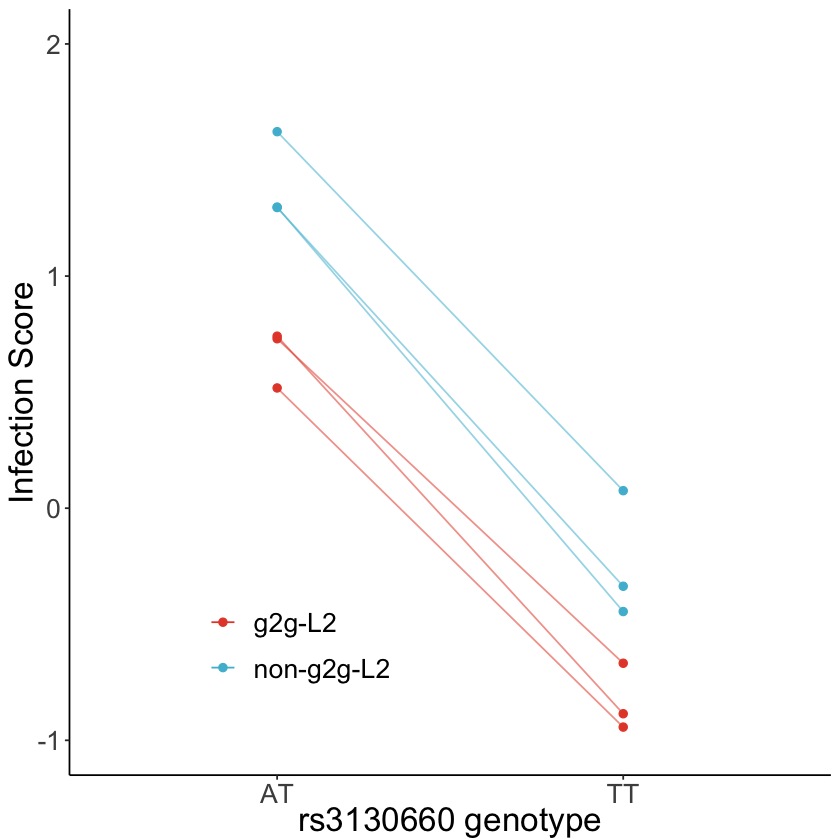

In [113]:
paired_FLOT <- ggplot(features.scores.use.pairwise_grouped_2, aes(x = FlotAllele, y = Score, group = Strain)) + 
  geom_line(aes(color = G2G, alpha=0.3)) + 
  geom_point(size = 2, aes(color = G2G)) +
  scale_color_manual(values = c("G2G" = clade_colors[1],
                                "Non-G2G" = clade_colors[2]), labels=c('g2g-L2','non-g2g-L2')) +
  guides(alpha=FALSE,
         color=guide_legend(title="", 
                            byrow=TRUE),size=16)+
  xlab("rs3130660 genotype") +
  ylab("Infection Score")


paired_FLOT + theme(legend.position=c(0.3,0.2)) + ylim(-1,2)

ggsave("../figures/Fig3a_infectionscore.png",width=6.5,height=5,dpi=300)

In [114]:
# paired t-test within g2g vs non-g2g groups
G2G <- subset(features.scores.use.pairwise_grouped_2,  
                 G2G == "G2G", Score,
                 drop = TRUE)
nG2G <- subset(features.scores.use.pairwise_grouped_2,  
                 G2G == "Non-G2G", Score,
                 drop = TRUE)
res_3 = t.test(G2G,nG2G, paired = TRUE)
res_3

# paired t-test within AT vs TT donors
AT <- subset(features.scores.use.pairwise_grouped_2,  
                 FlotAllele == "AT", Score,
                 drop = TRUE)
TT <- subset(features.scores.use.pairwise_grouped_2,  
                 FlotAllele == "TT", Score,
                 drop = TRUE)

res_4 = t.test(AT,TT, paired = TRUE)
res_4


	Paired t-test

data:  G2G and nG2G
t = -10.397, df = 5, p-value = 0.0001418
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.8347811 -0.5038270
sample estimates:
mean difference 
      -0.669304 



	Paired t-test

data:  AT and TT
t = 30.596, df = 5, p-value = 6.999e-07
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 1.435979 1.699408
sample estimates:
mean difference 
       1.567693 


# Fig3b, strain-specific volcano plot

In [115]:
g2gData <- read.table("../data/DE_g2gspecific.txt", sep=" ", header=T)
g2gData = na.omit(g2gData)

#Parameters
log2FoldChange=0.7
adjP=0.01
color1 =clade_colors[1]
color2 = "#C0C0C0"
color3 = clade_colors[2]
color <- c(up = color1, no_change = color2, down = color3)
alpha <- c(up = 0.8, no_change = 0.05, down = 0.8)

g2gData$color <- ifelse(g2gData$adjP<adjP &
                       abs(g2gData$log2FoldChange)>= log2FoldChange,
                     ifelse(g2gData$log2FoldChange > log2FoldChange,'up','down'),
                     'no_change')

g2gData$logFDR = -log10(g2gData$adjP)

g2gData$label = rep("", dim(g2gData)[1])
for(i in 1:dim(g2gData)[1]){
  if(g2gData$color[i]!="no_change"){
    g2gData$label[i] = g2gData$gene_symbol[i]}}

table(g2gData$color)



     down no_change        up 
      123     11800        61 

Warning message:
"ggrepel: 152 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 174 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


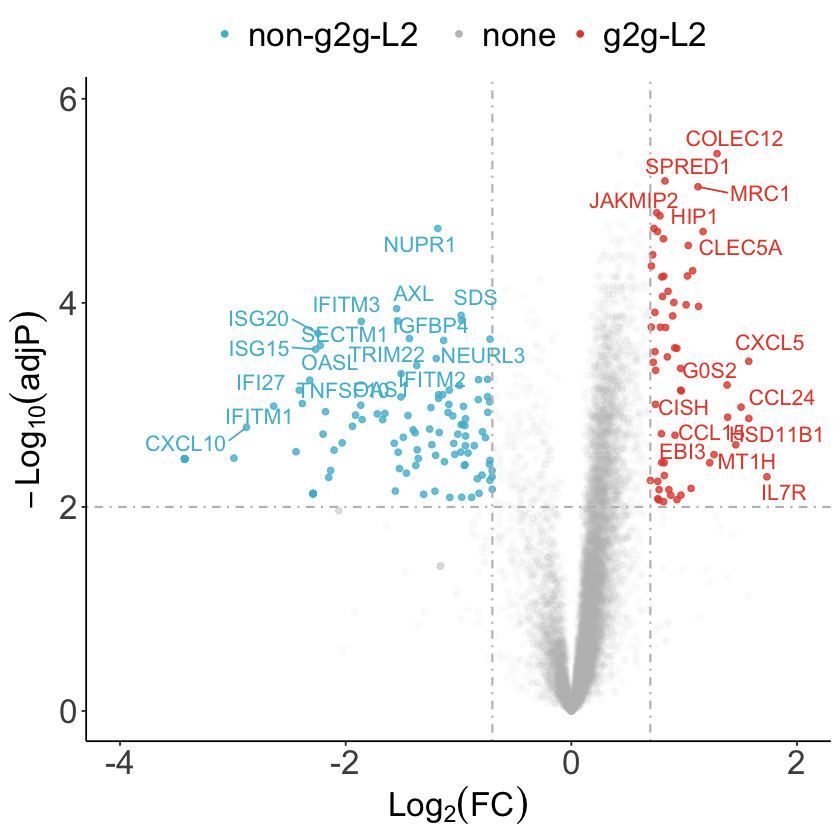

In [116]:
g2g.vplot <- ggplot(g2gData, aes(log2FoldChange, logFDR, col = color, alpha = color)) +
  geom_point() +
  scale_alpha_manual(values = alpha) +
  scale_color_manual(values = color,
                     name = "",
                     labels = c("non-g2g-L2","none","g2g-L2")) +
  xlim(-4,2) +
  #ylim(0,max(-log10(adjP[4:7]),na.rm=TRUE)) +
  geom_hline(yintercept = -log10(adjP), lty=4,col="grey",lwd=0.6) +
  geom_vline(xintercept = c(-log2FoldChange, log2FoldChange), lty=4,col="grey",lwd=0.6) +
  geom_text_repel(aes(log2FoldChange, logFDR, label = label, size = 3),
                  max.overlaps = 12,
                  alpha = 1,
                  show.legend = F) +
  ylab(bquote(-Log[10](adjP))) +
  xlab(bquote(Log[2](FC))) +
  guides(alpha = "none",
         size = "none") +
  theme_classic() +
  theme(legend.position = "top",
        panel.grid=element_blank(),
        legend.text=element_text(size=20),
        axis.title = element_text(size = 20),
        axis.text = element_text(size = 20))
g2g.vplot

ggsave("../figures/Fig3b_g2gspecific_volcano.png",width=6.5,height=5,dpi=300)

# Fig3c, donor-specific volcano

In [117]:
data <- read.table("../data/DE_infectedOnly_flot1specific_strain_random_effect.txt",
                  sep=" ", header=T)
data <- na.omit(data)

#Parameters
log2FoldChange=0.7
adjP=0.01
color1 = "#00A087FF"
color2 = "#C0C0C0"
color3 = "#3C5488FF"
color <- c(up = color1, no_change = color2, down = color3)
alpha <- c(up = 0.8, no_change = 0.05, down = 0.8)


In [118]:
data$color <- ifelse(data$adjP<adjP &
                       abs(data$log2FoldChange)>= log2FoldChange,
                     ifelse(data$log2FoldChange > log2FoldChange,'up','down'),
                     'no_change')

data$logFDR = -log10(data$adjP)

data$label = rep("", dim(data)[1])
for(i in 1:dim(data)[1]){
  if(data$color[i]!="no_change"){
    data$label[i] = data$gene_symbol[i]}}

table(data$color)


     down no_change        up 
      673     11618       251 

Warning message:
"ggrepel: 905 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 912 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


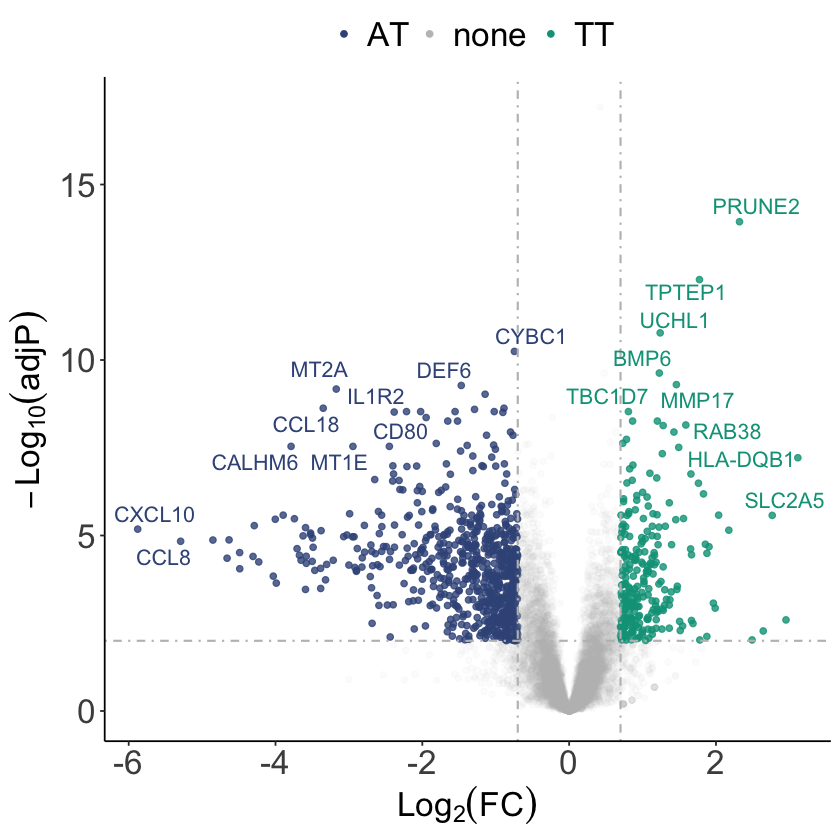

In [119]:
vplot <- ggplot(data, aes(log2FoldChange, logFDR, col = color, alpha = color)) +
  geom_point() +
  scale_alpha_manual(values = alpha) +
  scale_color_manual(values = color,
                     name = "",
                     labels = c("AT","none","TT")) +
  #xlim(-8,5) +
  #ylim(0,max(-log10(adjP[4:7]),na.rm=TRUE)) +
  geom_hline(yintercept = -log10(adjP), lty=4,col="grey",lwd=0.6) +
  geom_vline(xintercept = c(-log2FoldChange, log2FoldChange), lty=4,col="grey",lwd=0.6) +
  geom_text_repel(aes(log2FoldChange, logFDR, label = label, size = 3),
                  max.overlaps = 12,
                  alpha = 1,
                  show.legend = F) +
  ylab(bquote(-Log[10](adjP))) +
  xlab(bquote(Log[2](FC))) +
  guides(alpha = "none",
         size = "none") +
  theme_classic() +
   theme(legend.position = "top",
        panel.grid=element_blank(),
        legend.text=element_text(size=20),
        axis.title = element_text(size = 20),
        axis.text = element_text(size = 20))
vplot

ggsave("../figures/Fig3c_genotypespecific_volcano.png",width=6.5,height=5,dpi=300)

# Fig3d, heatmap

In [121]:
colData = read.csv("../data/metadata.csv", row.names = 1, header = T)
colData_infected = colData[-c(7,14,21,28,35,42),]

In [123]:
FLOT1_data = read.table("../data/DE_infectedOnly_flot1specific_strain_random_effect.txt",
                    sep=" ", head=T)

G2G_data = read.table("../data/DE_g2gspecific.txt",
                    sep=" ", head=T)

FLOT1_data_selected = FLOT1_data[(FLOT1_data$adjP<0.01 & abs(FLOT1_data$log2FoldChange)>0.7),c(8,11,9,10)]

G2G_data_selected = G2G_data[(G2G_data$adjP<0.01 & abs(G2G_data$log2FoldChange)>0.7),c(8,11,9,10)]

#FLOT1 gene number
dim(FLOT1_data_selected)[1]

[1] 926

In [124]:
#Union set
union_gene = rbind(FLOT1_data_selected, G2G_data_selected)
union_gene = union_gene[-which(duplicated(union_gene$ENSEMBL)==T),]
dim(union_gene)[1]

[1] 1002

In [125]:
TPM_all = read.csv("../data/TPM_all.csv",row.names = 1, head=T)
TPM_union_gene = TPM_all[TPM_all$ENSG %in% union_gene$ENSEMBL,]
TPM_union_gene = merge(TPM_union_gene, union_gene,
                       by.x = "ENSG", by.y = "ENSEMBL", all=F)

#Duplicated gene annotation
TPM_union_gene$gene_symbol[989] = "TPTEP1_2"
TPM_union_gene = TPM_union_gene[-c(687,806),]

row.names(TPM_union_gene) = TPM_union_gene$gene_symbol
TPM_union_gene = TPM_union_gene[c(2:43)]

TPM_union_gene_log = log2(TPM_union_gene+1)
TPM_union_gene_log_infected = TPM_union_gene_log[-c(7,14,21,28,35,42)]
TPM_union_gene_log_infected_zscore = as.data.frame(t(scale(t(TPM_union_gene_log_infected))))

In [180]:
average_infected_zscore = as.data.frame(matrix(ncol=4,nrow=dim(TPM_union_gene_log_infected_zscore)[1]))
names(average_infected_zscore) = c("ATxG2G","ATxnG2G","TTxG2G","TTxnG2G")
row.names(average_infected_zscore) = row.names(TPM_union_gene_log_infected_zscore)
for(i in 1:dim(average_infected_zscore)[1]){
  temp = as.vector(t(TPM_union_gene_log_infected_zscore[i,]))
  average_infected_zscore$ATxG2G[i] = mean(temp[c(1:3,7:9,13:15)])
  average_infected_zscore$ATxnG2G[i] = mean(temp[c(4:6,10:12,16:18)])
  average_infected_zscore$TTxG2G[i] = mean(temp[c(19:21,25:27,31:33)])
  average_infected_zscore$TTxnG2G[i] = mean(temp[c(22:24,28:30,34:36)])
}

#Heatmap
scale.col <- colorRamp2(c(-2,0,2), viridis(3))

#Heatmap annotation
ann_FLOTxG2G = data.frame(FLOT1xG2G= c("ATxG2G",
                                      "ATxnG2G",
                                      "TTxG2G",
                                      "TTxnG2G"))

# ann_colors_FLOTxG2G = list(FLOTxG2G = c("ATxG2G" = hue_pal()(4)[1],
#                                 "ATxnG2G" = hue_pal()(4)[2],
#                                 "TTxG2G" = hue_pal()(4)[3],
#                                 "TTxnG2G" = hue_pal()(4)[4]))
ann_colors_FLOTxG2G = list(FLOT1xG2G = c("ATxG2G" = "#bebebeb6",
                                "ATxnG2G" = "#3838380e",
                                "TTxG2G" = "#bebebeb6",
                                "TTxnG2G" = "#3838380e"))

In [181]:


colAnn_FLOTxG2G = HeatmapAnnotation(df = ann_FLOTxG2G,
                           which = 'col',
                           col = ann_colors_FLOTxG2G,
                           gap = unit(1,'mm'))

pa = cluster::pam(average_infected_zscore, k=5,
                  metric = "euclidean")

p1 = Heatmap(average_infected_zscore,
        col=scale.col,
        row_dend_gp = gpar(col = "#929292"),
        column_dend_gp = gpar(col = "#929292"),
        #rect_gp = gpar(col = "white", lwd = 0),
        top_annotation = colAnn_FLOTxG2G,
        show_row_names = F,
        show_column_names = F,
        cluster_rows = T,
        cluster_columns = T,
        row_split = factor(pa$clustering, levels=c(4,5,2,3,1)),
        heatmap_legend_param = list(
               direction = "horizontal",
               #title = expression("Z score of averaged gene expression Log2(TPM+1)"),
               title = expression("Z score of averaged gene expression"),
               title_position = "topcenter",
               title_gp = gpar(fontsize = 14),
               legend_width = unit(8, "cm"),
               labels_gp = gpar(fontsize = 12)))


Warning message:
"The input is a data frame-like object, convert it to a matrix."


In [182]:
png(file="../figures/Fig3d_heatmap.png",width=12,height=20,units="cm",res=500)
draw(p1, heatmap_legend_side = "bottom",
     annotation_legend_side = "right")

dev.off()

pdf 
  2

# Fig3e, pathway analysis

In [183]:
cluster1_gene = names(which(pa$clustering==2))
cluster2_gene = names(which(pa$clustering==3))
cluster3_gene = names(which(pa$clustering==4))
cluster4_gene = names(which(pa$clustering==1))
cluster5_gene = names(which(pa$clustering==5))


In [186]:
#Genes from clusters are subjected to pathway analysis (DAVID)


Cluster1 = read.csv("../data/Cluster1_pathway.csv")
Cluster1 = Cluster1[-c(1,4),]

Cluster2 = read.csv("../data/Cluster2_pathway.csv")
Cluster2 = Cluster2[-c(1,3,7),]
Cluster2$Term[4] = "MHC-I antigen presentation"

Cluster3 = read.csv("../data/Cluster3_pathway.csv")
Cluster3 = Cluster3[-c(1,2,3,6),]

Cluster4 = read.csv("../data/Cluster4_pathway.csv")
Cluster5 = read.csv("../data/Cluster5_pathway.csv")


Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"incomplete final line found by readTableHeader on '../data/Cluster4_pathway.csv'"
Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"incomplete final line found by readTableHeader on '../data/Cluster5_pathway.csv'"


In [190]:
pathway = rbind(Cluster1, Cluster2, Cluster3, Cluster4, Cluster5)
names(pathway)[1]<-"Cluster"
pathway$Term = factor(pathway$Term,
                      levels=c("Ribosome",
                               "Disulfide bond",
                               "Metabolism",
                               "Cytosolic DNA-sensing pathway",
                               "MHC-I antigen presentation",
                               "Interferon gamma signaling",
                               "Interferon alpha/beta signaling",
                               "Zinc homeostasis",
                               "IL-4 and IL-13 signaling",
                               "IL-10 signaling",
                               "Signaling by Interleukins"
                               ))



,Cluster,Category,Term,Count,X.,PValue,Genes,List.Total,Pop.Hits,Pop.Total,Fold.Enrichment,Bonferroni,Benjamini,FDR,Gene.ratio
,<chr>,<chr>,<fct>,<int>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,Cluster 1,REACTOME_PATHWAY,IL-4 and IL-13 signaling,8,5.517241,2.85e-05,"5295, 4609, 3553, 6367, 4312, 58480, 3383, 3606",91,108,10946,8.910053,1.692319e-02,4.316344e-03,4.316344e-03,0.05517241
3,Cluster 1,REACTOME_PATHWAY,Signaling by Interleukins,15,10.344828,2.89e-05,"5295, 7006, 6367, 1154, 3563, 58480, 3383, 4609, 3553, 3575, 4312, 5724, 11213, 3606, 10148",91,473,10946,3.814558,1.711743e-02,4.316344e-03,4.316344e-03,0.10344828
5,Cluster 1,REACTOME_PATHWAY,IL-10 signaling,5,3.448276,5.82e-04,"3553, 6367, 3383, 5724, 3606",91,47,10946,12.796353,2.939567e-01,4.349718e-02,4.349718e-02,0.03448276
6,Cluster 1,WIKIPATHWAYS,Zinc homeostasis,6,4.137931,2.35e-05,"4494, 4495, 4496, 64116, 4501, 7779",79,37,8200,16.832022,7.190314e-03,4.314051e-03,4.314051e-03,0.04137931
21,Cluster 2,KEGG_PATHWAY,Cytosolic DNA-sensing pathway,8,2.888087,7.52e-05,"3569, 103, 9447, 81030, 834, 3665, 23586, 3627",137,63,8205,7.605144,1.225425e-02,1.541186e-03,1.409622e-03,0.02888087
4,Cluster 2,REACTOME_PATHWAY,Interferon alpha/beta signaling,31,11.191336,9.04e-36,"8651, 6773, 6772, 24138, 3437, 3434, 3433, 4940, 9636, 4600, 54739, 10410, 3659, 10379, 5696, 11274, 10581, 91543, 3430, 2537, 2634, 4938, 684, 4939, 103, 4599, 8638, 3665, 3669, 8519, 3429",176,72,10946,26.777620,5.960000e-33,2.980000e-33,2.900000e-33,0.11191336


Warning message:
"The `guide` argument in `scale_*()` cannot be `FALSE`. This was deprecated in
ggplot2 3.3.4.
i Please use "none" instead."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning

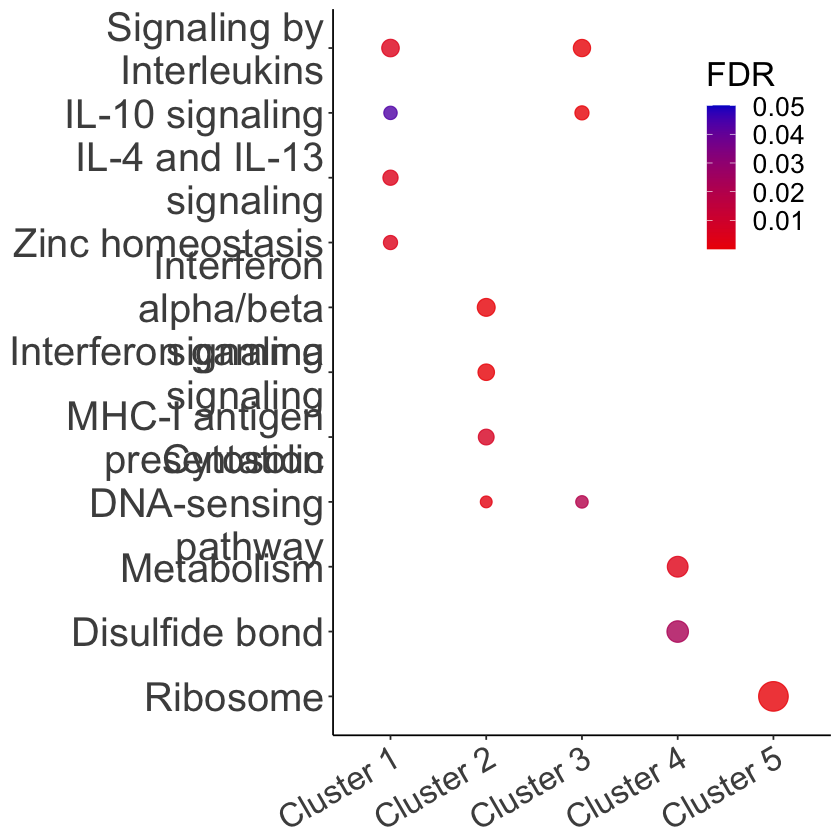

In [254]:
S1<- ggplot(pathway, aes(x= Cluster, y=Term, size=Gene.ratio, color=FDR)) +
  geom_point(alpha = 0.8) + 
  scale_color_gradient(low = "red2",  high = "mediumblue", 
                        space = "Lab", 
                        limit = c(3.160000e-34, 0.05)) +
  scale_size(range = c(3, 8),guide=FALSE) +
  theme(axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1, size=20),
        axis.text.y = element_text(size=24))
S1 +  guides(fill = guide_legend(nrow = 1))+   scale_y_discrete(labels = function(Term) stringr::str_wrap(Term, width = 18))+
 theme(legend.position=c(0.85,0.8))
ggsave("../figures/Fig3e_pathway.png",width=6.5,height=10,dpi=500)
